#### load a trained model

In [1]:
import tensorflow as tf
import numpy as np
import torch
import os
import argparse
os.environ["CUDA_VISIBLE_DEVICES"] = "1,0" 
from art.utils import  load_cifar10
from keras.datasets import  mnist
(x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_cifar10() 
best_model = tf.keras.models.load_model('checkpoint/')
optimizer = tf.keras.optimizers.SGD(0.0001, momentum=0.9)
best_model.compile(
        optimizer,
        loss = tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=['acc'])
best_model.evaluate(x_test,np.argmax(y_test,axis=1))

2022-10-27 21:04:00.470408: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-27 21:04:11.082953: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 17358 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:40:00.0, compute capability: 8.6
2022-10-27 21:04:11.083839: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 17358 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:3e:00.0, compute capability: 8.6
2022-10-27 21:04:38.797111: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8204


  3/313 [..............................] - ETA: 19s - loss: 0.5209 - acc: 0.9271

2022-10-27 21:04:42.530962: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


313/313 [==============================] - 27s 55ms/step - loss: 0.5941 - acc: 0.9418


[0.5941312909126282, 0.9417999982833862]

#### calculate the significant interfaces

In [2]:
from distutils.log import error
from tensorflow.keras import backend as K
from analysis import  cka_linear
import matplotlib.pyplot as plt
def get_activations(images, model, idx):
  """Return a list of activations obtained from a model on a set of images."""
  input_layer = model.input
  layer_outputs = [model.layers[idx].output]
  get_layer_outputs = K.function(input_layer, layer_outputs)
  activations = get_layer_outputs(images)
  return activations
#Testing four variations of adversarial attack distributions
def Deviation(model,layers,benign_sample,error_sample):
    deviations = []
    for attack_id in range(len(error_sample)):
        x_train_attack = error_sample[attack_id]
        sim1 = []
        for i in layers:
            out = get_activations(benign_sample,model,i+1)
            out1 = get_activations(x_train_attack,model,i+1)
            sim1.append(cka_linear(out[0].reshape(1000,-1), out1[0].reshape(1000,-1)))
        deviations.append(sim1)
        plt.ylim(0,1)
        plt.plot(range(len(layers)),sim1,marker='o',label='attack{}'.format(attack_id))
    plt.legend(loc=0, numpoints=1)
    plt.show()
    return deviations
def OrderOfImportance(deviations):
    
    l = len(deviations[0])
    score = [0]*l
    for d in deviations:
        for i in range(1,l):
            score[i]+=(d[i-1]-d[i])
    return score

the accuracy of adversarial_attack samples
32/32 [==============================] - 2s 67ms/step - loss: 1.0319 - acc: 0.1200


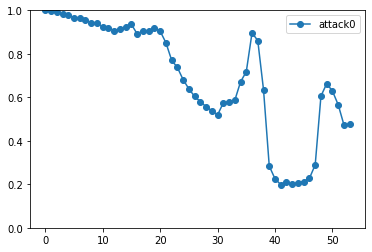

In [3]:
layers = torch.load('/ssd/rxn/property/resnet110_block.pt')
error_sample = []
for attack in [4]:
    x_train_attack = torch.load('/bdata/gg/experiments/adversial/attack{}_seed2.pt'.format(attack))
    print('the accuracy of adversarial_attack samples')
    best_model.evaluate(x_train_attack[0],np.argmax(x_train_attack[1],axis=1))
    error_sample.append(x_train_attack[0])
benign_sample =  x_train[0:1000] 

ans = Deviation(best_model,layers,benign_sample,error_sample)

In [4]:
import heapq
score = OrderOfImportance(ans)
sign = heapq.nlargest(5,range(len(score)),score.__getitem__)

#### train only some of the network layers

In [5]:
# freeze other layers and only update the parameters of the selected layers
def freeze(model,idxs):
    for i,layer in enumerate(model.layers): 
        if i in idxs:
            layer.trainable = True
        else:
            layer.trainable = False
f = []
for s in sign:
    f = f+ [i for i in range(layers[s-1]+2,layers[s]+3)]
freeze(best_model,f)
num = 0 
for l in best_model.layers:
    if l.trainable == True:
        num = num + 1
print('the number of trainable layers:',num)

the number of trainable layers: 38


In [6]:
# for the attack 4 , new training set 
benign_sample =  x_train[0:1000] 
x_train_attack = torch.load('/bdata/gg/experiments/adversial/attack4_seed2.pt')
x_train_attack[1].shape
x_new = np.append(benign_sample,x_train_attack[0],axis=0)
y_new = np.append(y_train[:1000],y_train[:1000],axis=0)
new_model = tf.keras.Model(inputs = best_model.input, outputs = best_model.layers[layers[sign[0]]].output)
temp = new_model(x_train[:1000])
y1_new = np.append(temp,temp,axis=0)
print(x_new.shape,y_new.shape,y1_new.shape)
best_model.evaluate(x_new,np.argmax(y_new,axis=1))

(2000, 32, 32, 3) (2000, 10) (2000, 8, 8, 64)
63/63 [==============================] - 3s 53ms/step - loss: 0.7280 - acc: 0.5600


[0.7279978394508362, 0.5600000023841858]

In [7]:
# loss = loss1 + loss2 
new_model = tf.keras.Model(inputs = best_model.input, outputs = [best_model.layers[layers[sign[0]]].output,best_model.output])
loss1 = tf.keras.losses.MeanSquaredError()
loss2 = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
new_model.compile(
        optimizer,
        loss = [loss1,loss2],
        loss_weights = [0.5,0.5],
        metrics=['acc'])

In [8]:
new_model.fit(x_new,[y1_new,np.argmax(y_new,axis=1)],shuffle=True,batch_size=128,epochs=10)

Epoch 1/10
16/16 [==============================] - 12s 153ms/step - loss: 0.7675 - add_39_loss: 0.5253 - dense_loss: 0.7485 - add_39_acc: 0.7228 - dense_acc: 0.7320
Epoch 2/10
16/16 [==============================] - 1s 90ms/step - loss: 0.6093 - add_39_loss: 0.5203 - dense_loss: 0.4372 - add_39_acc: 0.6837 - dense_acc: 0.8515
Epoch 3/10
16/16 [==============================] - 2s 98ms/step - loss: 0.5165 - add_39_loss: 0.4801 - dense_loss: 0.2916 - add_39_acc: 0.6837 - dense_acc: 0.9070
Epoch 4/10
16/16 [==============================] - 2s 96ms/step - loss: 0.4823 - add_39_loss: 0.4853 - dense_loss: 0.2182 - add_39_acc: 0.6641 - dense_acc: 0.9375
Epoch 5/10
16/16 [==============================] - 2s 99ms/step - loss: 0.4476 - add_39_loss: 0.4512 - dense_loss: 0.1829 - add_39_acc: 0.6720 - dense_acc: 0.9525
Epoch 6/10
16/16 [==============================] - 1s 94ms/step - loss: 0.4223 - add_39_loss: 0.4331 - dense_loss: 0.1505 - add_39_acc: 0.6740 - dense_acc: 0.9655
Epoch 7/10
16/

#### results of fix by training a small number of network layers

In [9]:
best_model.evaluate(x_new,np.argmax(y_new,axis=1))

63/63 [==============================] - 3s 55ms/step - loss: 0.7619 - acc: 0.9825


[0.7618712186813354, 0.9825000166893005]